<img align="left" src="https://panoptes-uploads.zooniverse.org/project_avatar/86c23ca7-bbaa-4e84-8d8a-876819551431.png" type="image/png" height=100 width=100>
</img>
<h1 align="right">Run machine learning models on footage</h1>
<h3 align="right"><a href="https://colab.research.google.com/github/ocean-data-factory-sweden/kso/blob/main/notebooks/publish/Publish_observations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a></h3>
<h3 align="right">Written by the KSO team</h3>

# Set up KSO requirements

### Install requirements and load KSO modules

Installing the requirements in Google Colab takes ~4 mins and might automatically crash/restart the session. Please run this cell until you get the "KSO successfully imported!" message.

In [1]:
%matplotlib inline
import os
import sys


def initiate_dev_version():
    kso_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    if os.path.isdir(os.path.join(kso_path, "kso_utils")):
        sys.path.insert(0, kso_path)
        %load_ext autoreload
        %autoreload 2
        print("Development mode ON - kso-utils added to the system.")
    else:
        raise FileNotFoundError("kso_utils directory not found in the expected path.")


def install_kso_utils():
    !pip install -q kso-utils
    # Temporary workaround to install panoptes from the source (avoid requests incompatibility)
    !pip install git+https://github.com/zooniverse/panoptes-python-client.git
    print("Restarting runtime to apply package changes...")
    os.kill(os.getpid(), 9)


try:
    initiate_dev_version()
    import kso_utils.widgets as kso_widgets
    import kso_utils.project_utils as p_utils
    import kso_utils.yolo_utils as y_utils
    from kso_utils.project import ProjectProcessor, MLProjectProcessor

    print("KSO dev successfully imported!")
except Exception as e:
    install_kso_utils()
    import kso_utils.widgets as kso_widgets
    import kso_utils.project_utils as p_utils
    import kso_utils.yolo_utils as y_utils
    from kso_utils.project import ProjectProcessor, MLProjectProcessor

    print("KSO PyPi successfully imported!")

Error importing kso modules: No module named 'kso_utils'
Development mode ON - kso-utils added to the system.
KSO successfully imported!


### Choose your project

In [2]:
project_name = kso_widgets.choose_project()

Dropdown(description='Project:', options=('Template project', 'Koster_Seafloor_Obs', 'Spyfish_Aotearoa', 'SGU'…

### Initiate project's database

In [3]:
# Find project
project = p_utils.find_project(project_name=project_name.value)
# Initialise pp
pp = ProjectProcessor(project)

INFO:root:Template project loaded succesfully
INFO:root:Retrieving the file from https://drive.google.com/uc?&confirm=s5vl&id=1PZGRoSY_UpyLfMhRphMUMwDXw4yx1_Fn
Downloading...
From: https://drive.google.com/uc?&confirm=s5vl&id=1PZGRoSY_UpyLfMhRphMUMwDXw4yx1_Fn
To: /Users/jurie.germishuys/Workspace/odf/koster-uw/kso/notebooks/publish/db_csv_info.zip
100%|██████████| 3.23k/3.23k [00:00<00:00, 3.45MB/s]
INFO:root:Updated species table from the temporary database
INFO:root:Updated sites table from the temporary database
INFO:root:Updated movies table from the temporary database


In [4]:
# Initialise mlp
mlp = MLProjectProcessor(pp)

INFO:root:ML Project successfully initialised.


# Run model on footage

### Choose the model

In [29]:
model = mlp.choose_model(publish=True)

ref-gu-4sp.zip downloaded successfully.


Dropdown(description='Select Zenodo model: ', options=(('ref-gu-4sp', 'models/best.pt'),), style=DescriptionSt…

### Choose folder to download the model

In [6]:
download_dir = kso_widgets.choose_folder(".", "where to download the model")

FileChooser(path='/Users/jurie.germishuys/Workspace/odf/koster-uw/kso/notebooks/publish', filename='', title='…

### Download model

In [7]:
artifact_dir = mlp.get_model(model.value, download_dir.selected)

INFO:root:Local model successfully loaded.


### Choose the footage to run the models into

In [8]:
pp.choose_footage_source()

RadioButtons(description='Choose footage source:', options=('Existing Footage', 'New Footage'), value='Existin…

In [9]:
pp.choose_footage()

INFO:root:Creating the available_movies_df attribute
/Users/jurie.germishuys/Workspace/odf/koster-uw/kso/kso_utils/movie_utils.py:207: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  available_movies_df["filename_ext"] = available_movies_df["fpath"].apply(
INFO:root:All 5 movies are mapped from the server
INFO:root:Information of available movies has been retrieved


SelectMultiple(description='Select movie(s):', layout=Layout(width='50%'), options=('movie_1.mp4', 'movie_2.mp…

INFO:root:Returning the fpath https://www.wildlife.ai/wp-content/uploads/2022/06/movie_1.mp4


In [10]:
# Ensure the selected footage and paths are loaded to the system
pp.check_selected_movies()

INFO:root:Returning the fpath https://www.wildlife.ai/wp-content/uploads/2022/06/movie_1.mp4


### Choose folder to save the runs

In [11]:
# This should be left as default value in most cases.
save_dir = kso_widgets.choose_folder(".", "runs output")

FileChooser(path='/Users/jurie.germishuys/Workspace/odf/koster-uw/kso/notebooks/publish', filename='', title='…

### Choose a confidence threshold for evaluation

In [12]:
conf_thres = kso_widgets.choose_conf()

FloatSlider(value=0.5, continuous_update=False, description='Confidence threshold:', max=1.0, readout_format='…

## Choose a suitable experiment name

In [13]:
exp_name = kso_widgets.choose_experiment_name()

Text(value='exp_name', description='Experiment name:', placeholder='Choose an experiment name', style=TextStyl…

### Run model over selected footage

In [15]:
# Get the paths of the movies selected
mlp.detect_yolo(
    save_dir=save_dir.selected,
    conf_thres=conf_thres.value,
    artifact_dir=artifact_dir,
    save_output=True,
    project=mlp.project_name,
    name=exp_name.value,
    model=model.value,
    out_format="yolo",
    source=(
        pp.selected_movies_paths
        if isinstance(pp.selected_movies_paths, str)
        else pp.selected_movies_paths[0]
    ),
)

Found https://www.wildlife.ai/wp-content/uploads/2022/06/movie_1.mp4 locally at movie_1.mp4


INFO:root:Processed item 1 / 253 in 1682.3630332946777 ms. Estimated remaining time: 423.96s. Grab a ☕
INFO:root:Processed item 2 / 253 in 1605.093240737915 ms. Estimated remaining time: 403.96s. Grab a ☕
INFO:root:Processed item 3 / 253 in 1597.7389812469482 ms. Estimated remaining time: 400.51s. Grab a ☕
INFO:root:Processed item 4 / 253 in 1597.2929000854492 ms. Estimated remaining time: 398.77s. Grab a ☕
INFO:root:Processed item 5 / 253 in 1594.6307182312012 ms. Estimated remaining time: 396.66s. Grab a ☕
INFO:root:Processed item 6 / 253 in 1596.1918830871582 ms. Estimated remaining time: 395.32s. Grab a ☕
INFO:root:Processed item 7 / 253 in 1600.5098819732666 ms. Estimated remaining time: 394.91s. Grab a ☕
INFO:root:Processed item 8 / 253 in 1658.614158630371 ms. Estimated remaining time: 408.34s. Grab a ☕
INFO:root:Processed item 9 / 253 in 1807.4214458465576 ms. Estimated remaining time: 442.17s. Grab a ☕
INFO:root:Processed item 10 / 253 in 1716.970443725586 ms. Estimated remain

Results saved to /Users/jurie.germishuys/Workspace/odf/koster-uw/kso/notebooks/publish/exp_name15
7 labels saved to /Users/jurie.germishuys/Workspace/odf/koster-uw/kso/notebooks/publish/exp_name15/labels


INFO:root:Prediction completed successfully! ✅
/Users/jurie.germishuys/Workspace/odf/koster-uw/kso/kso_utils/yolo_utils.py:1235: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  detect_df["movie_filename"] = detect_df["movie_filename"].apply(
INFO:root:Report created at /Users/jurie.germishuys/Workspace/odf/koster-uw/kso/notebooks/publish/exp_name15/annotations.csv


### View the processed footage

In [16]:
kso_widgets.select_viewer()

Dropdown(description='Select viewer:', options=('image', 'video'), value='image')

Output()

### Process the detections
Add the metadata associated with the species identified and the movies

In [15]:
mlp.eval_dir = (
    "/Users/jurie.germishuys/Workspace/odf/koster-uw/kso/notebooks/publish/exp_name7"
)

In [27]:
dets_df = pp.process_detections(
    project=pp.project,
    db_connection=pp.db_connection,
    csv_paths=pp.csv_paths,
    annotations_csv_path=mlp.eval_dir,
    model_registry=mlp.registry,
    model=model.value,
    team_name=mlp.team_name,
    project_name=mlp.project_name,
)

ERROR:root:Registry invalid.
INFO:root:Detections processed. The dataframe has a total of 1 rows and 31 columns


                                            filename  class_id  frame_no  \
0  /Users/jurie.germishuys/Workspace/odf/koster-u...         0         8   

          x         y         w         h      conf  
0  0.042244  0.685058  0.082922  0.104577  0.151638  


In [26]:
dets_df

,class_id,frame_no,x,y,w,h,conf,movie_filename,movie_id,commonName,...,siteName,fpath,decimalLatitude,decimalLongitude,geodeticDatum,countryCode,scientificName,taxonRank,kingdom,second_in_movie
0,0,8,0.042244,0.685058,0.082922,0.104577,0.151638,movie_1,1,NAN,...,Site_1,https://www.wildlife.ai/wp-content/uploads/202...,-39.052281,174.023941,WGS84,NZ,NaN,NaN,NaN,0


### Plot the processed detections

/Users/jurie.germishuys/Workspace/odf/koster-uw/kso/kso_utils/yolo_utils.py:2334: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  interval = pd.Grouper(key="seconds_since_reference", freq=str(int_length) + "S")


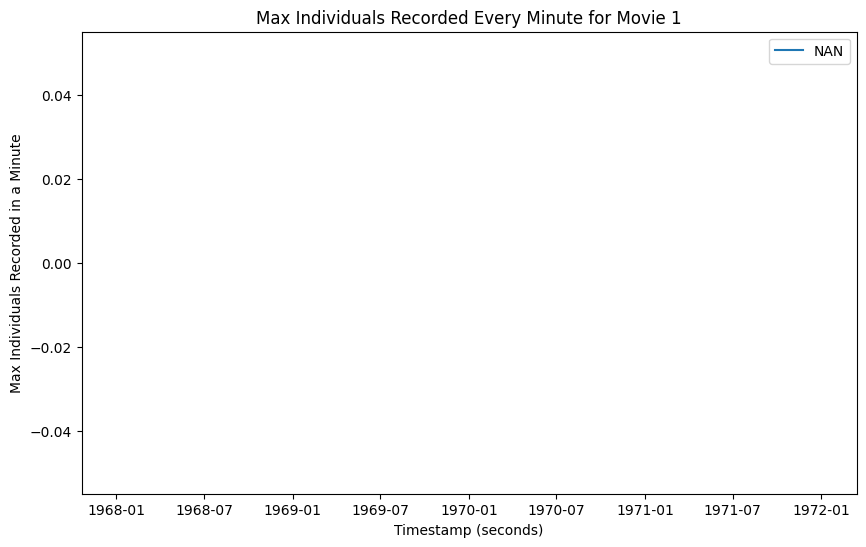

In [23]:
pp.plot_processed_detections(
    df=dets_df,
    thres=10,  # number of seconds for thresholding in interval
    int_length=10,  # length in seconds of interval for filtering
)

OPTIONAL #1 - Download the processed detections in a csv file for further analysis (e.g. comparisons between citizen scientists and experts)

In [24]:
pp.download_detections_csv(dets_df)

INFO:root:The detections have been downloaded to Template project2024-08-08detections.csv


OPTIONAL #2 - Processed classifications with species as columns (For biodiversity purposes)

In [ ]:
pp.download_detections_species_cols_csv(
    df=dets_df,
)

OPTIONAL #3 - Download maxN annotations in GBIF/OBIS format (For biodiversity purposes)

In [ ]:
pp.download_gbif_occurrences("ml_algorithms", dets_df)

OPTIONAL #4 - Upload csv with labels from previous model detections so that you can aggregate them for biogical analysis (For debugging purposes)

In [ ]:
mlp.widget_eval_dir = kso_widgets.choose_folder(
    (
        save_dir.selected
        if "save_dir" in vars() and save_dir.selected is not None
        else "."
    ),
    "runs output",
)

OPTIONAL #4 (Required!) - Load the path of the csv files

In [ ]:
mlp.eval_dir = mlp.widget_eval_dir.selected

In [ ]:
# END